In [1]:
from rdflib import Graph
from rdflib.namespace import RDF, OWL
from rdflib.term import BNode
from cmatcher.owl_utils import load_entities, load_cqas, load_sg, add_depth, to_pyg
from tqdm.auto import tqdm
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import degree
from torch_geometric.loader import DataLoader
from cmatcher.cqa_search import build_raw_data, build_graph_dataset, pad_seq, pad_entities, CQADataset
from torch_geometric.nn import MessagePassing
from multiprocessing_on_dill import Pool
from transformers import AutoTokenizer, BertModel, DistilBertModel
import torch.utils.checkpoint as checkpoint
import dill
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import time
import copy
import torch_geometric.nn as gnn
from torch_scatter import scatter_sum
from accelerate import Accelerator, notebook_launcher, DistributedDataParallelKwargs

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
paths = {
    'edas.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/edas.owl',
    'ekaw.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/ekaw.owl',
    'confOf.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/confOf.owl',
    'conference.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/Conference.owl',
    'cmt.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/cmt.owl',
}

cqa_path = '/projets/melodi/gsantoss/data/complex/CQAs'
entities_path = '/projets/melodi/gsantoss/data/complex/entities-cqas'

In [4]:
# paths = {
#     'edas.owl': '/home/guilherme/Documents/kg/conference/edas.owl',
#     'ekaw.owl': '/home/guilherme/Documents/kg/conference/ekaw.owl',
#     'confOf.owl': '/home/guilherme/Documents/kg/conference/confOf.owl',
#     'conference.owl': '/home/guilherme/Documents/kg/conference/Conference.owl',
#     'cmt.owl': '/home/guilherme/Documents/kg/conference/cmt.owl',
# }
# 
# cqa_path = '/home/guilherme/Documents/complex/CQAs'
# entities_path = '/home/guilherme/Documents/complex/entities-cqas'

In [5]:

idata = load_entities(entities_path, paths)
isg = load_sg(entities_path, paths)

cqas = load_cqas(cqa_path)
raw_data = build_raw_data(idata, cqas)


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [7]:
def sg_topg(s, ge, depth=4):
    eg = Graph()
    eg.add((s, RDF.type, OWL.Class))
    add_depth(s, eg, ge, depth)
    cm, pm, fm = to_pyg(s, eg)
    return s, cm, pm, fm


def build_raw_ts(op, data, workers=2):
    ge = Graph().parse(op)

    res = {}
    for k in data:
        tn, ng = data[k]
        res[k] = tn
        for t in ng:
            ge.add(t)

    mc = 0
    mp = 0
    ifd = []

    subjects = set(ge.subjects())

    with Pool(workers) as p:
        pgs = list(tqdm(p.imap(lambda x: sg_topg(x, ge, depth=4), subjects), total=len(subjects)))

    for s, cm, pm, fm in pgs:

        mcc = max(map(len, cm))
        mpc = max(map(len, pm))
        if mcc > mc:
            mc = mcc
        if mpc > mp:
            mp = mpc

        ifd.append((s, cm, pm, fm))

    return ifd, mc, mp, res


if os.path.exists('/projets/melodi/gsantoss/tmp/edas.pkl'):
    with open('/projets/melodi/gsantoss/tmp/edas.pkl', 'rb') as f:
        ifd, mc, mp, res = dill.load(f)
        print('loaded from cache.')
else:
    ifd, mc, mp, res = build_raw_ts('/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/edas.owl', isg['edas'],
                                    workers=6)
    with open('/projets/melodi/gsantoss/tmp/edas.pkl', 'wb') as f:
        dill.dump((ifd, mc, mp, res), f)


loaded from cache.


In [8]:
cidata = copy.deepcopy(idata)
del cidata['edas']

In [9]:
def clear_bn(ds):
    new_dataset = []
    for batch in ds:
        ps = tokenizer.decode(batch.x_sf[batch.x_s][batch.rsi][0]).replace('[PAD]', '').strip()
        if 'blank node' in ps or 'edas' in ps:
            continue
        
        ns = tokenizer.decode(batch.x_nf[batch.x_n][batch.rni][0]).replace('[PAD]', '').strip()
        
        if 'blank node' in ns or 'edas' in ns:
            continue
            
        new_dataset.append(batch)
        
    return new_dataset

In [10]:
class GNN(gnn.MessagePassing):
    def __init__(self):
        super(GNN, self).__init__(aggr='add')
        self.ln1 = nn.Linear(768, 768)
        self.ln2 = nn.Linear(768, 768)
        self.ln3 = nn.Linear(768, 768)
        self.ln4 = nn.Linear(768, 768)


    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        dg = degree(edge_index[1], x.shape[0])
        dg[dg == 0] = 1
        dg = dg.unsqueeze(-1).float()
        o1 = self.ln1(self.propagate(edge_index, x=x)) / dg + x
        o2 = self.ln2(self.propagate(edge_index, x=o1)) / dg + o1
        o3 = self.ln3(self.propagate(edge_index, x=o2)) / dg + o2
        o4 = self.ln4(self.propagate(edge_index, x=o3)) / dg + o3

        return o4

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]
        return x_j
    
    
    
edge_index = torch.tensor([[0, 1],
                           [1, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_attr=torch.ones((2, 1)))

g = GNN()


# print(g(x, edge_index, torch.ones((2, 1))))


In [11]:

    
    
class BertEmb(nn.Module):
    def __init__(self):
        super(BertEmb, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.bert.pooler.requires_grad_(False)

    def forward(self, x):
        mask = x > 0
        out = self.bert(input_ids=x, attention_mask=mask)['last_hidden_state']

        om = mask.unsqueeze(-1).float()

        mo = out * om
        cf = om.sum(dim=1)
        cf[cf == 0] = 1
        return mo.sum(dim=1) / cf


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.emb1 = BertEmb()
        # self.emb2 = BertEmb()
        self.gnn = GNN()

    def forward(self, cqa, x, xi, edge_index, edge_attr, edge_attr_i, nx, nxi, nedge_index, nedge_attr, nedge_attr_i):
        cqa = self.embed_cqa(cqa)

        sbg = self.embed_subg(x, xi, edge_index, edge_attr, edge_attr_i)
        nsbg = self.embed_subg(nx, nxi, nedge_index, nedge_attr, nedge_attr_i)

        return cqa, sbg, nsbg

    def embed_cqa(self, x):
        return self.emb1(x)

    def embed_subg(self, x, xi, edge_index, edge_attr, edge_attr_i):
        feats = []
        for f in TorchDataLoader(x, batch_size=4, shuffle=False):
            feats.append(checkpoint.checkpoint(self.emb1, f, use_reentrant=False))
            # feats.append(self.emb(f))
        feats = torch.cat(feats, dim=0)
        sf = feats[xi]
        
        out = checkpoint.checkpoint(self.gnn, sf, edge_index, edge_attr_i, use_reentrant=False)
        return out


model = Model()
device = torch.device('cuda:0')
# model.cuda(0)

In [12]:

    

dataset = CQADataset()


for batch in DataLoader(dataset, batch_size=2):
    print(batch)
    break

GraphDataBatch(rsi=[2], rpi=[2], rni=[2], cqs=[2, 429], cqp=[2, 429], cqn=[2, 429], x_s=[31], x_sf=[24, 459], x_p=[63], x_pf=[48, 459], x_n=[95], x_nf=[60, 459], edge_index_s=[2, 60], edge_index_p=[2, 168], edge_index_n=[2, 255], edge_feat_s=[60], edge_feat_sf=[16, 50], edge_feat_p=[168], edge_feat_pf=[18, 50], edge_feat_n=[255], edge_feat_nf=[22, 50])


100%|██████████| 546/546 [1:14:25<00:00,  8.18s/it]


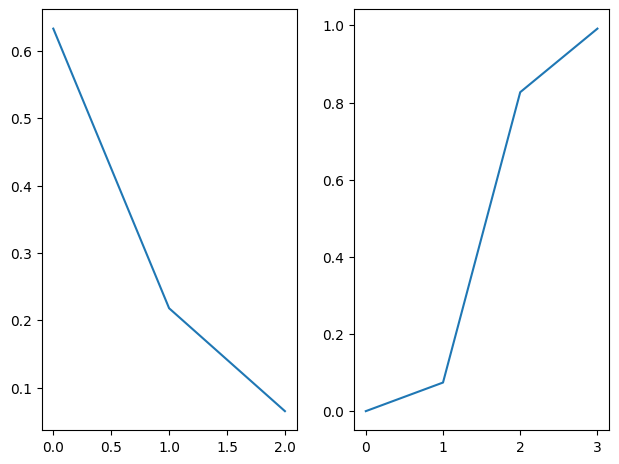

In [18]:
def sim_loss(cq, pe, ne):
    return torch.mean(1 - torch.cosine_similarity(cq, pe) + torch.cosine_similarity(cq, ne))

def evm(model, dataset, th=0.5):
    model.eval()

    res = []
    for batch in DataLoader(dataset, batch_size=2):
        with torch.no_grad():

            cqs = model.embed_cqa(batch.cqs.to(device))
            sbgs = model.embed_subg(batch.x_sf.to(device), batch.x_s.to(device),
                              batch.edge_index_s.to(device), batch.edge_feat_sf.to(device),
                              batch.edge_feat_s.to(device))
            


            isbgs = sbgs[batch.rsi]

            sim = torch.cosine_similarity(cqs, isbgs) > th
            res.append(sim)
            

    res = torch.cat(res, dim=0)

    return (res.sum() / res.size(0)).item()


optimizer = optim.AdamW(model.parameters(), lr=0.00001)

triplet_loss = nn.TripletMarginWithDistanceLoss(margin=0.9,
                                                distance_function=lambda x, y: 1.0 - nn.functional.cosine_similarity(x,
                                                                                                                     y))
cossine_loss = nn.CosineSimilarity()

lh = []
evh = []
epochs = 3
batch_size = 2
progress = None
for e in range(epochs):
    dataset = build_graph_dataset(tokenizer, cqas, cidata, raw_data['edas'])
    if not progress:
        progress = tqdm(total=epochs * math.ceil(len(dataset) / batch_size))
    evh.append(evm(model, dataset, th=0.9))

    model.train()
    
    el = []
    for batch in DataLoader(dataset, batch_size=batch_size):
        optimizer.zero_grad()
        cqs, sbgs, nsbg = model(batch.cqs.to(device), batch.x_sf.to(device), batch.x_s.to(device),
                          batch.edge_index_s.to(device), batch.edge_feat_sf.to(device), batch.edge_feat_s.to(device), batch.x_nf.to(device), batch.x_n.to(device),
                           batch.edge_index_n.to(device), batch.edge_feat_nf.to(device), batch.edge_feat_n.to(device))
        isbgs = sbgs[batch.rsi.to(device)]
        isbgn = nsbg[batch.rni.to(device)]

        loss = sim_loss(cqs, isbgs, isbgn)

        el.append(loss.item())
        loss.backward()

        optimizer.step()
        progress.update(1)

    lh.append(sum(el) / len(el))


evh.append(evm(model, dataset, th=0.9))

progress.close()
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(lh)
ax[1].plot(evh)
plt.show()

In [13]:
dataset = build_graph_dataset(tokenizer, cqas, cidata, raw_data['edas'])
dataset = clear_bn(dataset)

In [31]:
model = Model()
device = torch.device('cuda:0')
model.cuda(0)

optimizer = optim.AdamW(model.parameters(), lr=0.00001)

triplet_loss = nn.TripletMarginWithDistanceLoss(margin=0.9,
                                                distance_function=lambda x, y: 1.0 - nn.functional.cosine_similarity(x,
                                                                                                                     y))

In [12]:
for batch in DataLoader(dataset, batch_size=2):
    cqs, sbgs, nsbg = model(batch.cqs.to(device), batch.x_sf.to(device), batch.x_s.to(device),
          batch.edge_index_s.to(device), batch.edge_feat_sf.to(device), batch.edge_feat_s.to(device), batch.x_nf.to(device), batch.x_n.to(device),
           batch.edge_index_n.to(device), batch.edge_feat_nf.to(device), batch.edge_feat_n.to(device))
    isbgs = sbgs[batch.rsi.to(device)]
    isbgn = nsbg[batch.rni]
    
    print('cqa' + '=' * 20)
    print(tokenizer.decode(batch.cqs[0]).replace('[PAD]', '').strip())
    print(tokenizer.decode(batch.cqs[1]).replace('[PAD]', '').strip())
    print('pos' + '=' * 20)
    print(tokenizer.decode(batch.x_sf[batch.x_s][batch.rsi][0]).replace('[PAD]', '').strip())
    print(tokenizer.decode(batch.x_sf[batch.x_s][batch.rsi][1]).replace('[PAD]', '').strip())
    print('neg' + '=' * 20)
    print(tokenizer.decode(batch.x_nf[batch.x_n][batch.rni][0]).replace('[PAD]', '').strip())
    print(tokenizer.decode(batch.x_nf[batch.x_n][batch.rni][1]).replace('[PAD]', '').strip())
    print('sim' + '=' * 20)
    print(torch.cosine_similarity(cqs, isbgs), torch.cosine_similarity(cqs, isbgn))
    tl = triplet_loss(cqs, isbgs, isbgn)
    print(tl)
    sl = sim_loss(cqs, isbgs, isbgn)
    # sl.backward()
    print(sl)
    
    # optimizer.step()
    # 
    # cqs, sbgs, nsbg = model(batch.cqs.to(device), batch.x_sf.to(device), batch.x_s.to(device),
    #       batch.edge_index_s.to(device), batch.edge_feat_sf.to(device), batch.edge_feat_s.to(device), batch.x_nf.to(device), batch.x_n.to(device),
    #        batch.edge_index_n.to(device), batch.edge_feat_nf.to(device), batch.edge_feat_n.to(device))
    # isbgs = sbgs[batch.rsi.to(device)]
    # isbgn = nsbg[batch.rni]
    # 
    # print(torch.cosine_similarity(cqs, isbgs), torch.cosine_similarity(cqs, isbgn))
    # tl = triplet_loss(cqs, isbgs, isbgn)
    # print(tl)
    # sl = sim_loss(cqs, isbgs, isbgn)
    # print(sl)
    
    
    raise Exception('hue')

cqa====================
[CLS] select distinct? s where {? s < http : / / www. w3. org / 1999 / 02 / 22 - rdf - syntax - ns # type > < http : / / cmt # externalreviewer >. } [SEP]
[CLS] select distinct? s where {? s < http : / / www. w3. org / 1999 / 02 / 22 - rdf - syntax - ns # type > < http : / / cmt # author >. } [SEP]
pos====================
[CLS] http : / / cmt # externalreviewer [SEP]
[CLS] http : / / cmt # author [SEP]
neg====================
[CLS] http : / / confof # university [SEP]
[CLS] http : / / confof # banquet [SEP]
sim====================
tensor([0.5125, 0.8305], device='cuda:0', grad_fn=<SumBackward1>) tensor([0.1026, 0.0832], device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.3214, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4214, device='cuda:0', grad_fn=<MeanBackward0>)


Exception: hue

In [19]:
class IData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'rsi':
            return self.x_s.size(0)

        if key == 'x_s':
            return self.x_sf.size(0)

        if key == 'edge_index_s':
            return self.x_s.size(0)

        if key == 'edge_feat_s':
            return self.edge_feat_sf.size(0)

        return super().__inc__(key, value, *args, **kwargs)


def embed_subg(model, ifd, tokenizer, mc, mp):
    model.eval()
    ts = []
    graph_data = []
    ai = 0
    for s, cm, pm, fm in tqdm(ifd):

        pd1, pdi1 = pad_entities(tokenizer, cm, mc)

        pd3, pdi3 = pad_entities(tokenizer, pm, mp)

        edge1 = torch.LongTensor(fm)

        ts.append(s)
        graph_data.append(IData(
            rsi=torch.LongTensor([0]),

            x_s=pdi1.long(),
            x_sf=pd1.long(),

            edge_index_s=edge1.long(),

            edge_feat_s=pdi3,
            edge_feat_sf=pd3,

        ))

        ai += 1

    fe = []
    for batch in tqdm(DataLoader(graph_data, batch_size=2, shuffle=False)):
        with torch.no_grad():
            out = model.embed_subg(batch.x_sf.cuda(0), batch.x_s.cuda(0), batch.edge_index_s.cuda(0),
                                   batch.edge_feat_sf.cuda(0), batch.edge_feat_s.cuda(0))
            fe.append(out[batch.rsi])

    fe = torch.cat(fe, dim=0)

    return ts, fe


model.eval()
model.cuda(0)
root_entities, graph_embeddings = embed_subg(model, ifd, tokenizer, mc, mp)

100%|██████████| 262/262 [02:44<00:00,  1.59it/s]


In [20]:
def embed_cqas(model, data, tokenizer):
    model.eval()
    cq = []
    cqi = []
    ai = 0
    for k in data:
        cq.append(k)
        cqi.append(data[k])
        ai += 1

    cqid = tokenizer(cqi, return_tensors='pt', padding=True)['input_ids']

    cqeb = []

    for c in DataLoader(cqid, batch_size=2, shuffle=False):
        with torch.no_grad():
            out = model.embed_cqa(c.cuda(0))
            cqeb.append(out)

    cqeb = torch.cat(cqeb, dim=0)
    return cq, cqeb


model.eval()
cq, cqeb = embed_cqas(model, cqas['edas'], tokenizer)

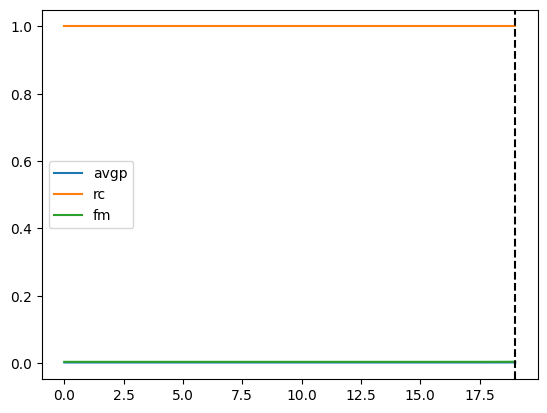

best threshold: 0.95
avgp: 0.00, rec: 1.00, afm: 0.00


In [21]:
def eval_metrics(cqa_list, cqa_embeddings, fe, ts, res, th=0.8):
    metrics = []

    for cqa_name, e in zip(cqa_list, cqa_embeddings):

        sim = torch.cosine_similarity(e.unsqueeze(0), fe, dim=1)
        resid = torch.where(sim > th)[0].tolist()
        rs = set()
        for r in resid:
            rs.add(ts[r])

        metrics.append((1 if res[cqa_name] in rs else 0, len(rs)))

    avgp = sum([1 / m[1] if m[1] > 0 else 0 for m in metrics]) / len(metrics)
    rc = sum([m[0] for m in metrics]) / len(metrics)
    fm = 2 * rc * avgp / (rc + avgp) if rc + avgp > 0 else 0
    return avgp, rc, fm


avgps = []
rcs = []
fms = []

for t in torch.arange(0, 1, 0.05):
    avgp, rc, fm = eval_metrics(cq, cqeb, graph_embeddings, root_entities, res, th=t)
    avgps.append(avgp)
    rcs.append(rc)
    fms.append(fm)

# avgp, rc, fm = eval_metrics(cq, cqeb, graph_embeddings, root_entities, res, th=0.70)

plt.plot(avgps, label='avgp')
plt.plot(rcs, label='rc')
plt.plot(fms, label='fm')
plt.legend()
# verical line on max fm
bv = torch.tensor(fms).argmax().item()
plt.axvline(x=bv, color='black', linestyle='--')

plt.show()

print(f'best threshold: {bv * 0.05:.2f}')
print(f'avgp: {avgps[bv]:.2f}, rec: {rcs[bv]:.2f}, afm: {fms[bv]:.2f}')